<font color="#84567D"> Author: Mahmud Hasan  </font>  <br>

License : MIT


<div class="alert alert-block alert-success">
<h4>Notebook Title: Sea level rising trend  in the Mediterranean Sea </h4>

##  Contents 
* [Data used](#section1)

* [Downloading data](#section2)

* [SLA trend analysis](#section3) 


Data source : Wekeo
Data products : Sea level daily gridded data from satellite altimetry 


[Back to top](#TOC_TOp)

Uploading Python packages 

In [3]:
import numpy as np
import glob
import inspect
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import warnings
from mpl_toolkits.basemap import Basemap
import xarray as xr
import scipy 
from scipy import stats
from hda import Client  
import json
import zipfile
from scipy import signal 
from eofs.standard import Eof

In [1]:
# Create a download directory for the target dataset 
# download_dir = os.path.join(os.getcwd(), "sla")
# os.makedirs(download_dir, exist_ok=True)
#c= Client ()

# matches = c.search(query)
# for match in matches.results:
#     fdst = match['filename']
#     print(f"Found: {fdst}")
    
#download 
#matches.download()


<a id='section1'></a>[Back to top](#TOC_TOP)

downloading the dataset from the Wekeo Dias portal

In [4]:
# ralative path, change according to system/PC 
rdir="/Users/mahmud/statistics/plot_exercises/sla_dir/"
path ="/Volumes/LaCie_poseidone/sla_93-20/"

#files_dir= os.path.join(path)
files= glob.glob(path+"*.nc")

## Reading single file and retrieve  lat , lon values
file =xr.open_dataset(files[0])
lat = file.variables["latitude"][:]
lon =file.variables["longitude"][:]
t = file["time"]
nlat= len(lat)
nlon = len(lon)

# target vairables specification 
sla= file["sla"][:]
ugva = file["ugosa"][:]   # geotropic velocity anomalies U- zonal component
vgva =file["vgosa"][:]  # geotropic velocity anomalies :V-meridonial component 

sla_files=xr.open_mfdataset(files,combine='nested',parallel=True, concat_dim= ['time'])
sla_series=sla_files["sla"][:]

## Finding  sea point indices in model grids
#- Western Mediterranean 
alb= [-3.7, 36.05]  # Alboran sea  location
lion=[ 5.1, 41.6]   # Gulf of Lion locaiton
tyr = [12.1, 39.5]  #  Tyrrhenian Sea location
sic = [12.0, 36.5]  # Scility strait locaiton 
#- Eastern Mediterrnean 
adr= [18, 41.7]    # Adriatic ne location
agean = [24.8, 36.2] #Agean sea new locaiton
ionian= [18.7,36.7] # Iionnian ea new locaiton
levantine= [32.8, 33.2] # Levantine sea new locaiton
  

# creating out and figs directory 
outpath= rdir+ "sla_figs/"
if not os.path.isdir(outpath):
    os.mkdir(outpath)
analysis = rdir + "sla_analysis/"
if not os.path.isdir(analysis):
    os.mkdir(analysis)


<a id='section1'></a>
[Back to top](#TOC_TOP)

Selecting random locations for single grid time series analysis 

In [239]:
# function for single grid location values

def single_grid(lati,long,loc):
    loc_ln = np.where(long>loc[0])[0]
    loc_lt = np.where(lati>loc[1])[0]
    loc_grid=[loc_ln[0],loc_lt[0]]
    return loc_grid
  
alb_loc=single_grid(lat,lon, alb)             #Alboran sea
lione_loc= single_grid(lat, lon, lion)        # Gulf of Lione

agean_loc=single_grid(lat,lon, agean)         # Agean Sea
levan_loc= single_grid(lat, lon, levantine)   # Levantine Sea

lon_list1 =list([alb_loc[0],lione_loc[0]])
lat_list1=list([alb_loc[1], lione_loc[1]])
lon_list2 =list([ agean_loc[0],levan_loc[0]])
lat_list2=list([agean_loc[1],levan_loc[1]])


def sgrid_values(series, list1, list2):
    loc_val = []
    for i in range(2):
        sl_value = series[:,list1[i],list2[i]]
        loc_val.append(sl_value)
    return loc_val

west=sgrid_values(sla_series,lat_list1, lon_list1)
east=sgrid_values(sla_series, lat_list2, lon_list2)


# --- SLA trend analysis 

## masking land point 
sla_series=np.nan_to_num(sla_series)   # putting -100 to avoid the observed values, by deafult it's 0  
sla_mask = np.ma.masked_where(sla_series==0, sla_series)

dtrend= np.zeros((sla_mask.shape))

dtrend[:,:,:]= signal.detrend(sla_mask[:,:,:],axis=0, type='linear')

sla_trend= sla_mask[:,:,:]-dtrend[:,:,:]
%time

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 14.1 µs


#Section4 [Back to top](#top)

Plotting section for  SLA data analyses 


In [274]:
len(west_trend[0])/365

27.44109589041096

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


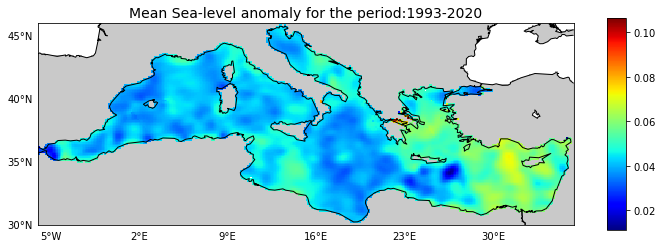

In [250]:
#--Plot-1: mean SLA for the period 1993-2020

sla_mean= np.mean(sla_mask, axis=0)
#sla_mean = np.ma.masked_where(sla_mean==0, sla_mean)

fig,ax =plt.subplots(1,1,figsize=(12,6))
for iplot in range(1):
    for zplot in range(1):
        m= Basemap(projection='cyl', resolution='l',llcrnrlat= 30,urcrnrlat= 46, llcrnrlon= -6.0, urcrnrlon = 36.4)
        m.drawcoastlines(linewidth=1)
        m.drawparallels(range(30,48,5), linewidth=0, dashes=[0, 1], labels=[1,0,0,1], color='r', zorder=0 )
        m.drawmeridians(range(-5, 36, 7), linewidth=1, dashes=[0, 1], labels= [1,0,0,1])
        m.fillcontinents(alpha=0.9)
        m.drawlsmask(land_color='0.7', ocean_color='w', resolution='l', grid=5, lsmask_lons=None )
        cb= plt.pcolor(lon,(lat),sla_mean[:,:], cmap="jet", vmin= sla_mean.min(), vmax=sla_mean.max())
        plt.colorbar(cb,orientation ="vertical", shrink =0.65, aspect=11, pad=0.05)
        plt.title("Mean Sea-level anomaly for the period:1993-2020", size=14)
%time     
plt.savefig(analysis+"sla_mean_1993.2020.jpeg",dpi=100)

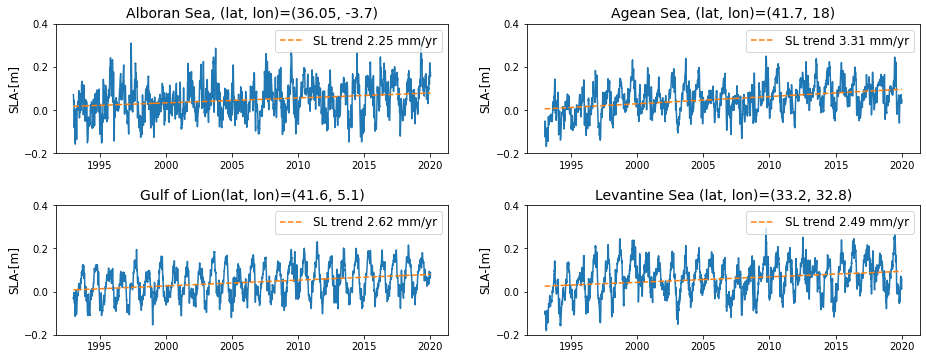

In [279]:
##--Plot2: Time series analysis with sea level rising trend in the Mediterranean Sea(MedSea)

sea1 = ["Alboran Sea, ","Gulf of Lion"]    #Easter MedSea
sea2=  [ "Agean Sea, ", "Levantine Sea "]  # Western MedSea
sea1_locs = [alb, lion]
sea2_locs=  [adr, levantine]


west_trend=sgrid_values(sla_trend,lat_list1, lon_list1)
east_trend=sgrid_values(sla_trend,lat_list2, lon_list2)

alb_trend=(((west_trend[0][-1]- west_trend[0][0])/10016)*365)*1000
lione_trend= (((west_trend[1][-1]-west_trend[1][0])/10016)*365)*1000
agean_trend=(((east_trend[0][-1]- east_trend[0][0])/10016)*365)*1000
levan_trend= (((east_trend[1][-1]- east_trend[1][0])/10016)*365)*1000

west_trnd_rate= np.array([alb_trend, lione_trend])
east_trnd_rate= np.array([agean_trend, levan_trend])

fig,ax =plt.subplots(2,2,figsize=(15,6))
yr=np.linspace(1993, 2020, 10016)

for iplot in range(2):
    for zplot in range(2):    

        if zplot==0:
            ax[iplot][zplot].plot(yr, west[iplot] ) 
            #ax1[1].plot(yr, sla_list[1]) 
            ax[iplot][zplot].plot(yr, west_trend[iplot], '--', label="SL trend "+"{:.2f}".format(west_trnd_rate[iplot])+ " mm/yr") 
            ax[iplot][zplot].set_title(sea1[iplot]+ "(lat, lon)=("+str(sea1_locs[iplot][1])+", "+str(sea1_locs[iplot][0])+")", fontsize=14) 
            #ax[iplot][zplot].set_xlabel(plot_info[0], size='13')
            ax[iplot][zplot].set_ylim(-0.2, 0.4)  

        if zplot==1:
          
            ax[iplot][zplot].plot(yr, east[iplot])
            ax[iplot][zplot].plot(yr, east_trend[iplot],'--', label="SL trend "+"{:.2f}".format(east_trnd_rate[iplot])+ " mm/yr")
            r_range=[-0.2, 0.4]
            ax[iplot][zplot].set_title(sea2[iplot]+ "(lat, lon)=("+str(sea2_locs[iplot][1])+", "+str(sea2_locs[iplot][0])+")", fontsize=14)
#             ax[iplot][zplot].set_xlabel(plot_info[0], size='13')
            ax[iplot][zplot].set_ylim(r_range[0], r_range[1])
             
        ax[iplot][zplot].legend(facecolor='inherit', fontsize=12, loc="upper right")
        ax[iplot][zplot].set_ylabel("SLA-[m]", size ='12' )

    plt.subplots_adjust(left=0.11, bottom=0.08, right=0.91, top=0.80, wspace=0.2, hspace=0.4)

plt.savefig(analysis+"time_series_trend_1993.2020.jpeg",dpi=100)

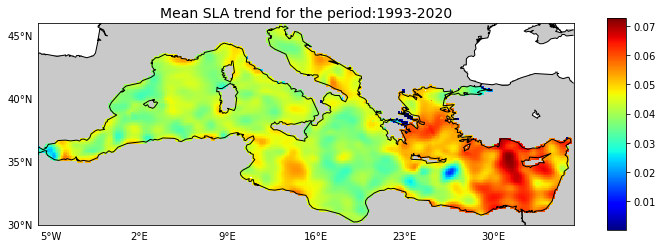

In [280]:
#- plot3- Sealevel trend analysis in the MedSea for the period 1993-2020: section1

sla_trend_icept = sla_trend[0,:,:]  # INtercept 
sla_trend_slp= sla_trend[1,:,:,]-sla_trend[0,:,:]  ##.  Slope

sla_trend_mean= np.mean(sla_trend, axis=0)

fig,ax =plt.subplots(1,1,figsize=(12,6))
for iplot in range(1):
    for zplot in range(1):
        m= Basemap(projection='cyl', resolution='l',llcrnrlat= 30,urcrnrlat= 46, llcrnrlon= -6.0, urcrnrlon = 36.4)
        m.drawcoastlines(linewidth=1)
        m.drawparallels(range(30,48,5), linewidth=0, dashes=[0, 1], labels=[1,0,0,1], color='r', zorder=0 )
        m.drawmeridians(range(-5, 36, 7), linewidth=1, dashes=[0, 1], labels= [1,0,0,1])
        m.fillcontinents(alpha=0.9)
        m.drawlsmask(land_color='0.7', ocean_color='w', resolution='l', grid=5, lsmask_lons=None )
        cb= plt.pcolor(lon,(lat),sla_trend_mean[:,:], cmap="jet")
        plt.colorbar(cb,orientation ="vertical", shrink =0.65, aspect=11, pad=0.05)
        plt.title("Mean SLA trend for the period:1993-2020", size=14)
plt.savefig(analysis+"sla_mean_trend_1993_2020.jpeg",dpi=100)

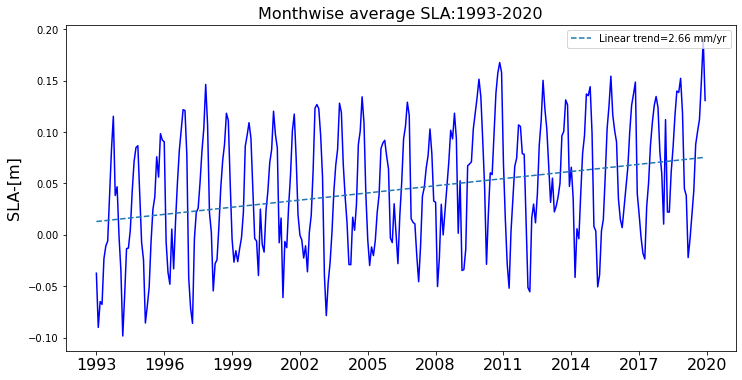

In [281]:
##--plot4 - SLA trend analysis section2
dt=pd.date_range(start='1993-01-01', end='2020-06-03',freq='D')
sla_mask=xr.DataArray(sla_mask,dims=['time','lat','lon'], coords= dict(time=dt))
sla_trend=xr.DataArray(sla_trend,dims=['time','lat','lon'], coords= dict(time=dt))


sla_surf_mean= np.mean(sla_mask, axis= (1,2))

yr_d1= pd.date_range(start='1993-01-01',end= '2020-01-01',freq='YS')
yr_d365= pd.date_range(start='1993-12-31',end= '2020-06-03',freq='Y')


def surface_monthly_mean(xarr): 
    monwise_mean= []
    idx=0
    for i in range(27):
        yr_slice=xarr.sel(time=slice(yr_d1[i],yr_d365[i]) )
        #yr_slice=xr.DataArray(yr_slice,dims=['time','lat','lon'])
        months_mean=yr_slice.groupby('time.month').mean('time')
        monwise_mean.append(months_mean)
        i+=1
    surf_mmn_series= np.concatenate(monwise_mean, axis=0)
    return surf_mmn_series

sla_surf_mm=surface_monthly_mean(sla_surf_mean)   # surface/basin averaged month-wise mean 
sla_mon_mn=np.repeat((np.average(sla_surf_mm)),360)  # surface/basin averaged SLA 

sla_trend_surfmn =np.mean(sla_trend, axis=(1,2))
sla_tr_sfmn_mon= surface_monthly_mean(sla_trend_surfmn)   # monthwise trend values for 27 yrs

def surface_yrly_mean(xarr):
    yrwise_mean= []
    idx=0
    for i in range(27):
        yrs_slice=xarr.sel(time=slice(yr_d1[i],yr_d365[i]) )
        #yr_slice=xr.DataArray(yr_slice,dims=['time','lat','lon'])
        yrs_mean=yrs_slice.groupby('time.year').mean('time')
        yrwise_mean.append(yrs_mean)
        i+=1
    surf_yrmn_series= np.concatenate(yrwise_mean, axis=0)
    return surf_yrmn_series 

sla_yrs_mn = surface_yrly_mean(sla_surf_mean)
sla_rate= ((sla_yrs_mn[-1]-sla_yrs_mn[0])/27)*1000  

# -- yearly time series for x -axis
xdata= np.arange(0,(2020-1993+1)*12,12*3 )
xlabels= np.arange(1993, 2020+1, 3)

# ---plotting of surface monthly mean
fig,axs=plt.subplots(1,1,figsize=(12,6))
#plt.sca(axs[1,1])
plt.plot( sla_surf_mm,'-b', label="")
plt.plot(sla_tr_sfmn_mon,'--', label="Linear trend="+ "{:.2f}".format(sla_rate)+ " mm/yr")

plt.title("Monthwise average SLA:1993-2020",fontsize=16)
plt.legend(facecolor='inherit', fontsize=10, loc="upper right")
plt.ylabel("SLA-[m]",fontsize=16,labelpad= 6)
plt.xticks(xdata,xlabels)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='minor', labelsize=22)
#plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig(analysis+"monthy_avg_trend_1993_2020.jpeg",dpi=100)

In [25]:
##-Plot-5 Spatial-temporal variation with EOF/PC analysis 
lat_val=lat.values
lons, lats= np.meshgrid(lon, lat)
## creating Weighted array 
coslat= np.cos(np.deg2rad(lat_val))
wgts = np.sqrt(coslat)[..., np.newaxis]

In [114]:
eof_solv= Eof(sla_mask, weights=wgts)
eof_n= eof_solv.eofsAsCorrelation(neofs=3)

In [283]:
# principal components(PCs with normalization )
pcm= eof_solv.pcs(npcs=3, pcscaling=1)
pcm_df= pd.DataFrame(pcm, index=sla_files['time'], columns=['EOF%s' % (x) for x in range(1, pcm.shape[1]+1)])
pcm_array=np.array(pcm_df)


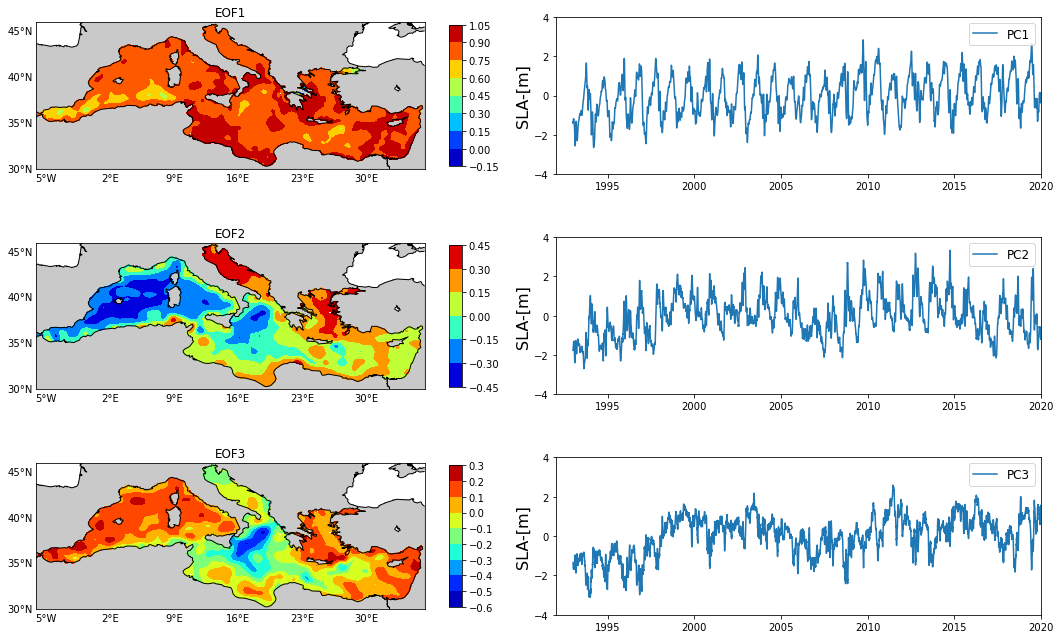

In [353]:

fig,ax =plt.subplots(3,2,figsize=(18,11))
yr=np.linspace(1993, 2020, 10016)

for iplot in range(3):
    for zplot in range(2):  
        
        if zplot==0:
            
            m= Basemap(projection='cyl', resolution='l',llcrnrlat= 30,urcrnrlat= 46, llcrnrlon= -6.0, urcrnrlon = 36.4, ax=ax[iplot][zplot])
            m.drawcoastlines(linewidth=1)
            m.drawparallels(range(30,48,5), linewidth=0, dashes=[0, 1], labels=[1,0,0,1], color='r', zorder=0 )
            m.drawmeridians(range(-5, 36, 7), linewidth=1, dashes=[0, 1], labels= [1,0,0,1])
            m.fillcontinents(alpha=0.9)
            m.drawlsmask(land_color='0.7', ocean_color='w', resolution='l', grid=5, lsmask_lons=None )
            cb=ax[iplot][zplot].contourf(lons,(lats),eof_n[iplot,:,:].squeeze(), cmap="jet")  #√levels=np.arange(-1, 1, 0.1)
            plt.colorbar(cb, ax=ax[iplot][zplot], orientation ="vertical", shrink =0.9, aspect=11, pad=0.05)
            titles= ["EOF1", "EOF2", "EOF3"]
            ax[iplot][zplot].set_title(titles[iplot])  
            #plt.title("EOF-1",fontsize=16)

        if zplot==1:
            level= ["PC1", "PC2", "PC3"]
            ax[iplot][zplot].plot(yr,pcm_array[:,iplot], label=level[iplot])
            ax[iplot][zplot].set_ylim(-4, 4)
            ax[iplot][zplot].set_xlim(1992, 2020)
            ax[iplot][zplot].legend(facecolor='inherit', fontsize=12, loc="upper right")
            ax[iplot][zplot].set_ylabel("SLA-[m]",fontsize=16,labelpad=3)
        fig.subplots_adjust(hspace =0.4, wspace=0.07)

plt.savefig(analysis+"EOF_PCs_1993_2020.jpeg",dpi=100)